# Human Protein Atlas Image Classification
Classify subcellular protein patterns in human cells 

Description from Kaggle: 

*Proteins are “the doers” in the human cell, executing many functions that together enable life. Historically, classification of proteins has been limited to single patterns in one or a few cell types, but in order to fully understand the complexity of the human cell, models must classify mixed patterns across a range of different human cells.*

*Images visualizing proteins in cells are commonly used for biomedical research, and these cells could hold the key for the next breakthrough in medicine. However, thanks to advances in high-throughput microscopy, these images are generated at a far greater pace than what can be manually evaluated. Therefore, the need is greater than ever for automating biomedical image analysis to accelerate the understanding of human cells and disease.*

This **notebook** Is run through the **Google Colab** notebook. Make sure to click
Runtime --> Change runtime type --> Hardware Accelerator--> **GPU**

## What we will do
We will be utilizing **Fastai v1.0** library. 

Steps will be: 
* Installing packages & libraries
* Downloading data from kaggle - You will need a Kaggle account, grab your API key and Accept terms for the competition
* Evaluate and preprocess data
* Create data transformations & data augmentations
* Create our first data object (sz=64)
* Define metrics to measure (F-Score)
* Create our first model (Pre-trained resnet34)
  * Find optimal learning rate
  * Train with optimal learning rate
  * Unfreeze all layers - allowing us to update all parameters
  * Find optimal learning rates
  * Train model once more with learning rate differentials (a range)
* Create a new data object, this time with (sz=128)
  * Freeze all layers - training last few layers only
  * Find optimal learning rate
  * Train model with optimal learning rate
  * Unfreeze all layers - allowing us to update all parameters
  * Find optimal learning rates
  * Train model once more with learning rate differentials (a range)
* Create another data object, (sz=256)
  * Freeze all layers
  * Find optimal learning rate
  * Train model with new optimal learning rate
  * Unfreeze layers
  * Find optimal learning rates
  * Train model once more with learning rate differentials
* Let's now observe our top losses
  * What can we conclude from our data?
  * What can we do to improve our data?
* Test with valid dataset

### 1. Installing Packages & Libraries
The very first thing is getting set up with Kaggle, downloading the Fastai library and other necessary libraries

In [0]:
# Installing Kaggle API
!pip install kaggle --upgrade

In [0]:
# Installing fastai v1.0 library
!pip install fastai

In [0]:
# PRIVATE
kaggle_cred = {"username":"USERNAME","key":"KEY"}

In [0]:
# Creating kaggle directory (will store credentials)
!mkdir .kaggle

In [0]:
# Dumping credentials into kaggle directory
import json

cred = json.dumps(kaggle_cred)

with open('.kaggle/kaggle.json', 'w') as f:
  f.write(cred)

In [0]:
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [0]:
# Let's now configure the kaggle credentials - This needs to run TWICE hence duplication (running once will cause an error (only on google colab))
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [0]:
# Let's now make it private as there is an error indicating our API key is readable by other users
!chmod 600 /root/.kaggle/kaggle.json

### 2. Downloading the data from kaggle
Make sure you have installed the Kaggle API and have created a kaggle.json file with your credentials otherwise the following code will not work. 

In [0]:
# Creating test and train directories - will store images
!mkdir /content/test | mkdir /content/train

In [0]:
# Path to our current working directory
PATH = '/content'
PATH_TRAIN = '/content/train'
PATH_TEST = '/content/test'

In [0]:
# Downloading the data we need for the comeptiton Test & Training images
!kaggle competitions download -c human-protein-atlas-image-classification -f train.zip -p {PATH}
!kaggle competitions download -c human-protein-atlas-image-classification -f test.zip -p {PATH}


In [0]:
# Downloading CVS file with labels
!kaggle competitions download -c human-protein-atlas-image-classification -f train.csv -p {PATH}

In [0]:
# Let's now check our current dictory to see if we have all files
import os

os.listdir(PATH)

In [0]:
# Now we have to unzip our data and store in current directory
!unzip -q -n {PATH}/train.zip -d {PATH_TRAIN}
!unzip -q -n {PATH}/test.zip -d {PATH_TEST}

In [0]:
# Uncomment lines to check directories 

os.listdir(PATH)
# os.listdir(PATH_TRAIN)
# os.listdir(PATH_TEST)

In [16]:
# Let's clear up some space by removing the zip files (taking up much space)
os.remove(f'{PATH}/train.zip')
os.remove(f'{PATH}/test.zip')

os.listdir(PATH)

['.config', '.kaggle', 'train', 'train.csv', 'test', 'sample_data']

### 3. Exploring Data
Now that we have downloaded all our data and placed them into their appropriate directories, let's take some time to understand what the data is

In [0]:
# Importing pandas and fastai.vision
import pandas as pd
from fastai.vision import *

In [0]:
# Let's read the csv into a pandas dataframe
labels = pd.read_csv(f'{PATH}/train.csv')

In [19]:
labels.head(10)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
5,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0
6,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0
8,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0
9,002daad6-bbc9-11e8-b2bc-ac1f6b6435d0,7


#### Target Id values
0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings 

So, from looking at this csv, we can see that each image has corresponding targets. Which would make sense since these cell contains different organelles 

(DISCLAIMER: I am not a biologist, though I did study Neurobiology in College)

In [20]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31072 entries, 0 to 31071
Data columns (total 2 columns):
Id        31072 non-null object
Target    31072 non-null object
dtypes: object(2)
memory usage: 485.6+ KB


### 4. Creating data object
We will now begin utilizing the fastai v1.0 library to further look at the data and eventually build and train our models 

The very first thing we need to figure out is: *What sort of transformations and data augmentations should we apply to our data?* 

This is unique question for every dataset we tackle

Next, we will apply those and create a *data*  object using the *datablock API* which is provided by the fastai 1.0 library

Some research gives us some pointers as to some augmentation strategies to implement [Link to paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5977656/):

Since we are utilizing fastai version 1.0 we will be using the **get_transform** [Link to documentation](https://docs.fast.ai/vision.transform.html) 

We will be using: 
* do_flip=True
* flip_vert=True
* max_rotation = default, we will later experiment with different values
* max_zoom = default, we will later experiment with different values

In [0]:
# Setting transformation parameters

do_flip = True
flip_vert = True
max_rotate = 10.0
max_zoom = 1.05 # not default, but will start smaller

# Creating our transformation object
tfms = get_transforms(do_flip=do_flip, flip_vert=flip_vert, max_rotate=max_rotate, max_zoom=max_zoom)


In [0]:
# Creating our first data object using datablock API

np.random.seed(42)

sz = 64 # we will begin with a small size, every data object we create will be larger
data = (ImageItemList.from_csv('/content', 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.2)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats))

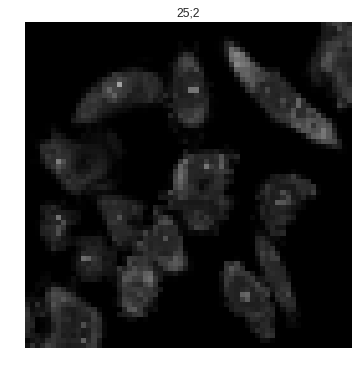

In [28]:
# Let's check some of the data
ds = data.train_ds
img, label = ds[19]
img.show(figsize=(6,6), title=label)

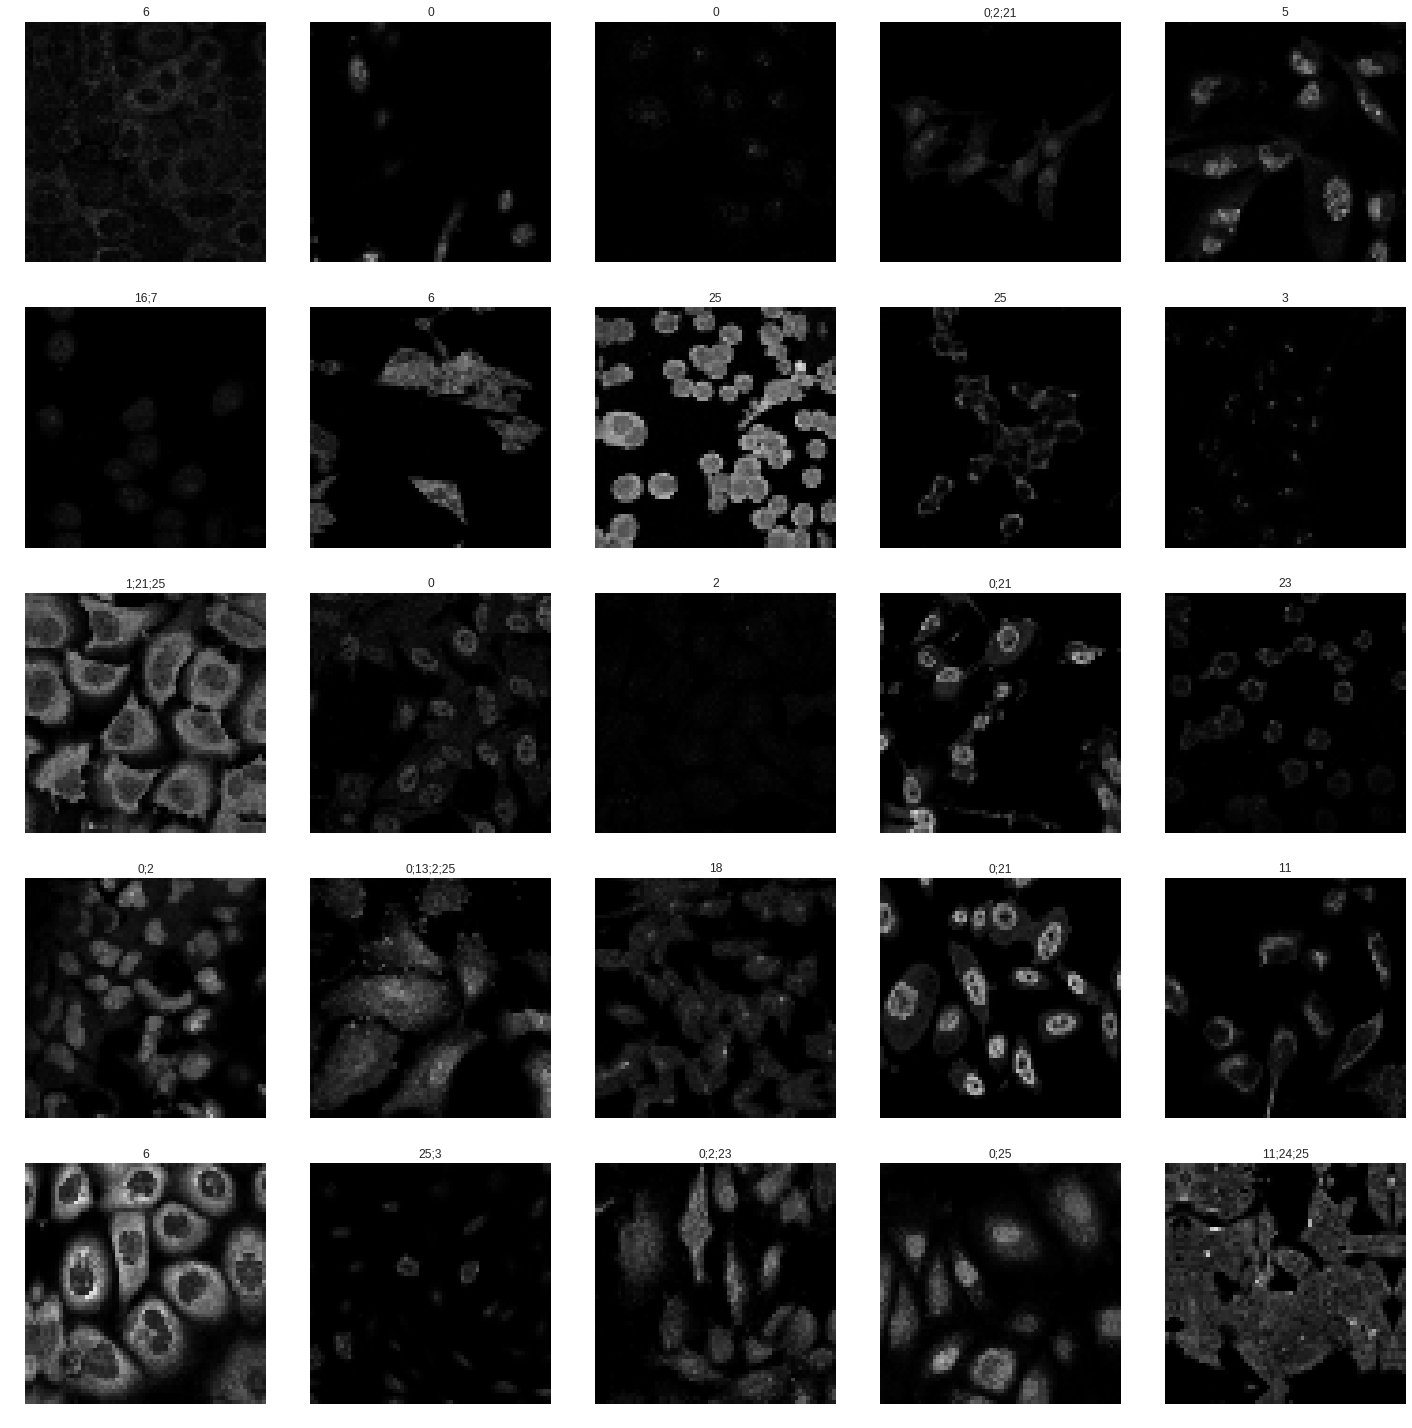

In [29]:
data.show_batch()

In [0]:
# Setting metrics to measure
acc = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

### 5. Creating simple model
To begin we will be using a pretrained resnet34 model we will 
* find optimal learning rate
* train with optimal learning rate, 5 epochs
* unfreeze layers - so we adjust all parameters
* find optimal learning rates
* train with differential (range) of learning rates

In [0]:
# Selecting Arch
arch = models.resnet34

In [0]:
# Creating our learner
learn = create_cnn(data, arch, metrics=[acc, f_score])

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


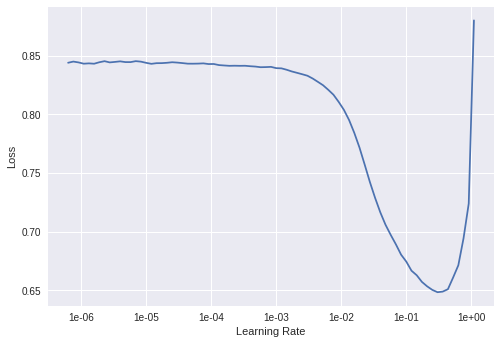

In [44]:
# Finding optimal learning rate 
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# seleting lr
lr = 0.07

In [46]:
# 1st training
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.175762,0.173279,0.923882,0.406450
2,0.183214,0.243944,0.920738,0.370296
3,0.173306,0.198584,0.931733,0.411447
4,0.158000,0.183928,0.928905,0.453772
5,0.153156,0.153307,0.935158,0.465867


In [0]:
# Let's save the model
learn.save('stage-1.01-64-resnet34')

In [0]:
# Unfreeze all layers
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


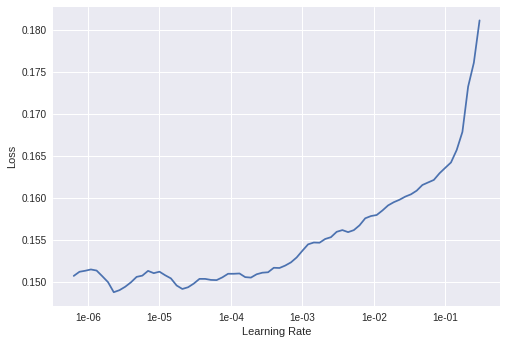

In [49]:
# Finding optimal learning rates
learn.lr_find()
learn.recorder.plot()

In [0]:
# Defining range of learning rates
lr1 = 0.00001
lr2 = 0.001

In [58]:
# 2nd training
learn.fit(5, slice(lr1, lr2)) # this should be learn.fit_one_cycle()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.151579,0.156014,0.935135,0.465652
2,0.151024,0.145989,0.935514,0.480170
3,0.148766,0.224950,0.934606,0.492159
4,0.146568,0.147229,0.937377,0.498471
5,0.147934,0.148684,0.937722,0.498551


In [0]:
# Saving stage 2
learn.save('stage-2-64-resnet34')

### 6. Creating a new data object
So now that we have trained our first model, we will continue but with a new data object 

What will be different here is the image sizes will be 128x128 

In [0]:
# Creating new data object

sz = 128 # We now increase the size to 128x128

data = (ImageItemList.from_csv('/content', 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.2)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats))

In [0]:
learn.data = data

In [0]:
# Now we have to freeze all the layers
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


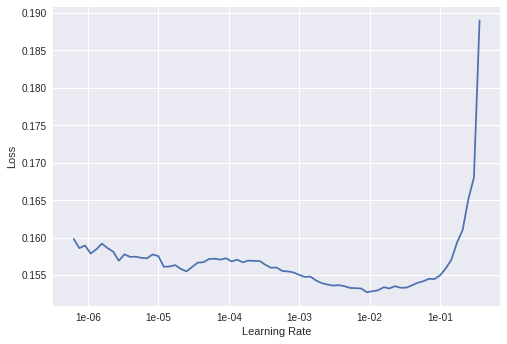

In [63]:
# finding optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [0]:
# Picking new learning rate
lr = 1e-2/2 # 0.005

In [70]:
learn.fit_one_cycle(5, slice(lr)) # run this only up to 4 epochs

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.146832,0.141256,0.938112,0.525138
2,0.143011,0.140478,0.939785,0.553797
3,0.139469,0.143046,0.939336,0.563149
4,0.138916,0.142102,0.940089,0.574794
5,0.137081,0.134061,0.941353,0.570709


In [0]:
# Saving this model
learn.save('stage-1-128-resnet34')

In [0]:
# Unfreezing the layers
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


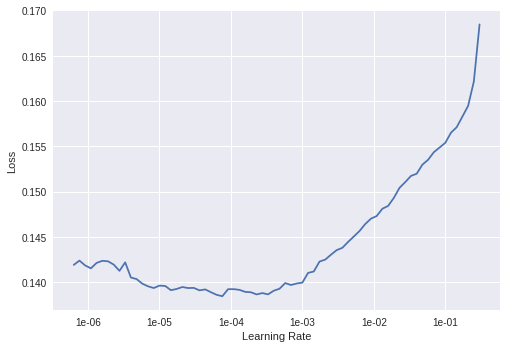

In [73]:
# let's find optimal learning rates
learn.lr_find()
learn.recorder.plot()

In [0]:
# Picking optimal learning rates
lr1 = 0.00001
lr2 = 0.001

In [78]:
# Training model once again
learn.fit_one_cycle(5, slice(lr1, lr2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.139678,0.134900,0.939354,0.568302
2,0.136478,0.131129,0.941405,0.569515
3,0.132840,0.128643,0.942779,0.590582
4,0.131693,0.125389,0.944055,0.606241
5,0.128459,0.131260,0.944273,0.609703


In [0]:
# Saving the model
learn.save('stage-2-128-resnet34')

### 7. Create another Data object
This time, our images will be of size 256. 

We will repeat as before

In [0]:
# Creating new data object

sz = 256 # We now increase the size to 256x256

data = (ImageItemList.from_csv('/content', 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.2)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats))

learn.data = data

In [0]:
# Freeze the layers
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


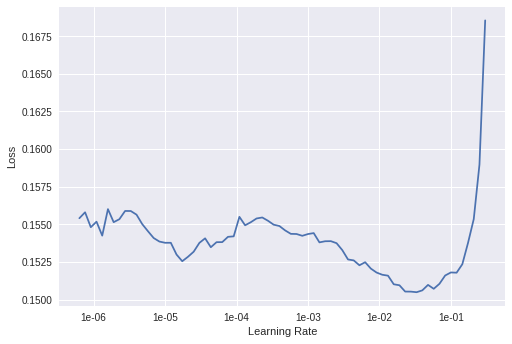

In [82]:
# Find optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [0]:
# picking optimal learning rate
lr = 0.03

In [84]:
# Training the model
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.138205,0.196918,0.947331,0.531779
2,0.142225,0.137274,0.943107,0.587090
3,0.132404,0.193482,0.942089,0.627778
4,0.126110,0.137887,0.947716,0.637722
5,0.119828,0.113890,0.947866,0.660633


In [0]:
# let's now save the model
learn.save('stage-1-256-resnet34')

In [0]:
# Loading model
learn.load('stage-1-256-resnet34')

In [0]:
sz = 512 # We now increase the size to 512x512

data = (ImageItemList.from_csv('/content', 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.2)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats))

learn.data = data

In [0]:
# freezing layers
learn.freeze()

In [0]:
# Finding optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [99]:
!ls

models	sample_data  test  train  train.csv
